In [1]:
import pickle
import os

FOLDER = os.getcwd() + "/10cells"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    psf = pickle.load(file)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np
from utils import *
from skimage.transform import rescale


In [3]:
#Rescale out to size mask

print("Pre-scaling:", out.shape)
out = rescale(out, mask.shape[0]/out.shape[0], anti_aliasing=False)
print("Post-scaling:", out.shape)

/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/sit

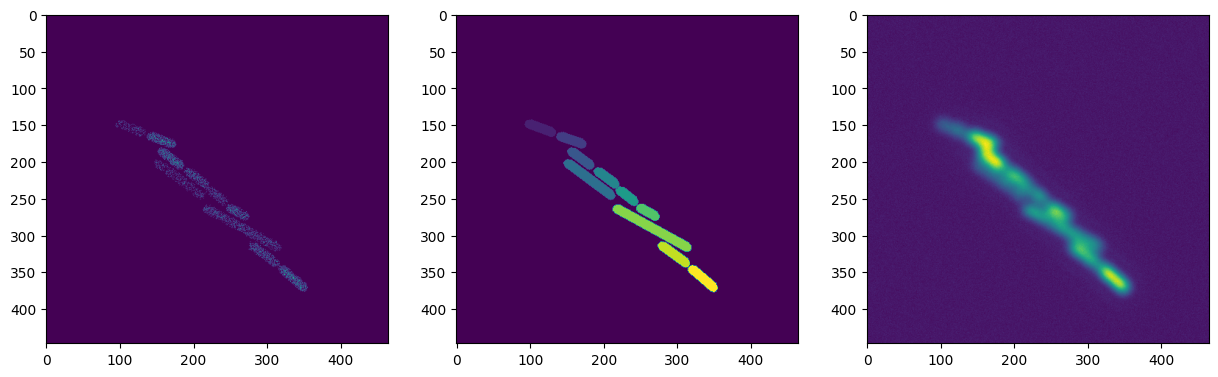

In [4]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

In [5]:
randomPts = 0
originalOutput = out
sourcePts = GetSourcePts(mask)
recoveredImage = InverseMatrix(out, mask, sourcePts, learningRate = 1, psf=psf)

[1.5259022e-05, 3.0518044e-05, 4.5777066e-05, 6.103609e-05, 7.629511e-05, 9.155413e-05, 0.00012207218, 0.0001373312, 0.00015259022, 0.00016784924]


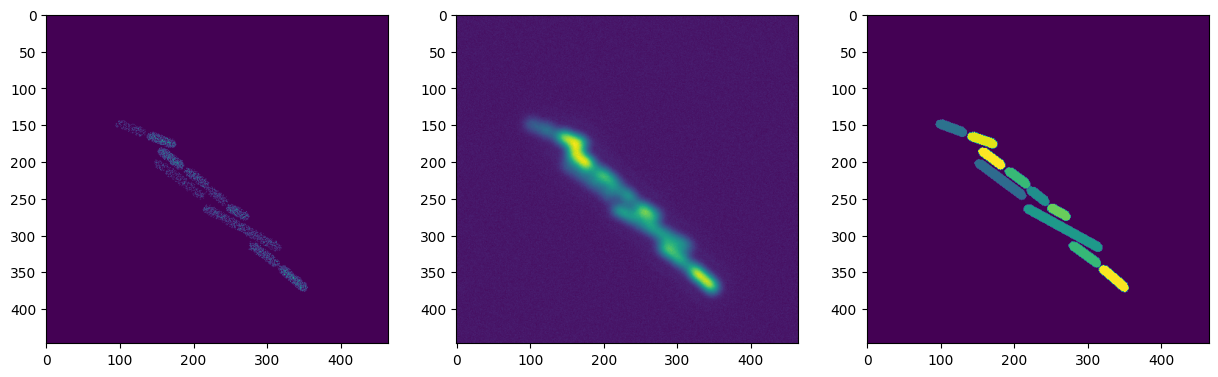

In [ ]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(out)
axarr[2].imshow(recoveredImage)
plt.show()

array([[1.        , 0.32444077],
       [0.32444077, 1.        ]])

/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/sit

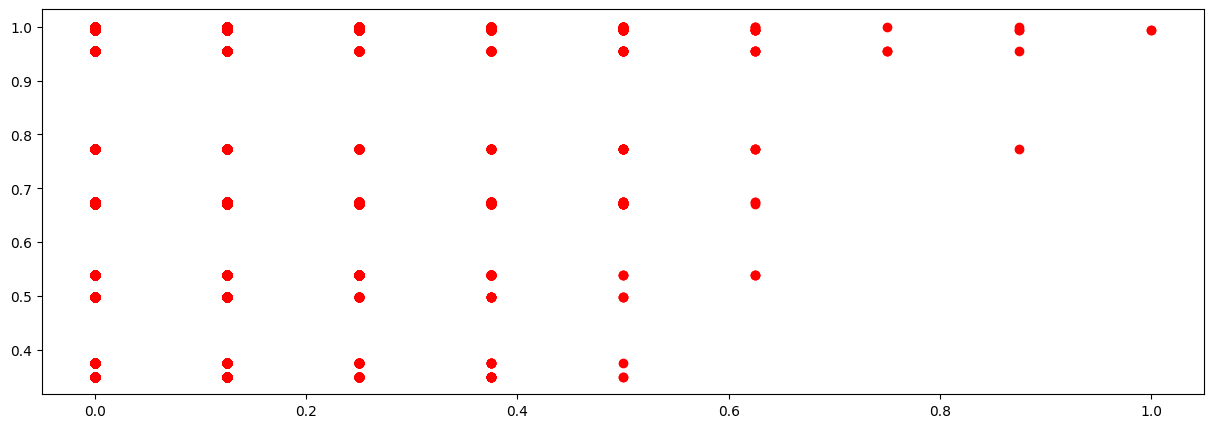

In [ ]:
original_intensity = []
custom_intensity = []


for x in sourcePts:
    original_intensity.append(ori[x[0],x[1]])
    custom_intensity.append(recoveredImage[x[0],x[1]])

original_intensity = np.array(original_intensity)
original_intensity = original_intensity/max(original_intensity)
custom_intensity = np.array(custom_intensity)
custom_intensity = custom_intensity/max(custom_intensity)

plt.plot(original_intensity,custom_intensity,'ro')

#Calculate correlation coefficient
np.corrcoef(original_intensity,custom_intensity)

/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/sit

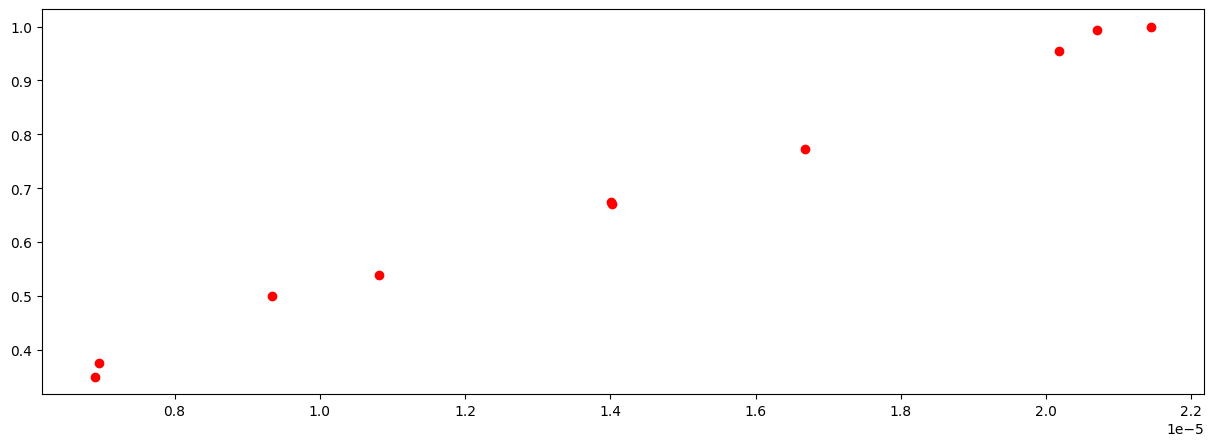

array([[1.        , 0.99807475],
       [0.99807475, 1.        ]])

In [ ]:
#Get average intensity in each mask

average_original_intensity = {}
for x in sourcePts:
    if not mask[x[0],x[1]] in average_original_intensity:
        average_original_intensity[mask[x[0],x[1]]] = [ori[x[0],x[1]],1]
    else:
        average_original_intensity[mask[x[0],x[1]]][0] += ori[x[0],x[1]]
        average_original_intensity[mask[x[0],x[1]]][1] += 1

average_custom_intensity = {}
for x in sourcePts:
    if not mask[x[0],x[1]] in average_custom_intensity:
        average_custom_intensity[mask[x[0],x[1]]] = [recoveredImage[x[0],x[1]],1]
    else:
        average_custom_intensity[mask[x[0],x[1]]][0] += recoveredImage[x[0],x[1]]
        average_custom_intensity[mask[x[0],x[1]]][1] += 1


average_original_intensity = [ v[0]/v[1] for k, v in average_original_intensity.items() ]
average_original_intensity = np.array(average_original_intensity)
average_inteaverage_original_intensitynsity = average_original_intensity/max(average_original_intensity)

average_custom_intensity = [ v[0]/v[1] for k, v in average_custom_intensity.items() ]
average_custom_intensity = np.array(average_custom_intensity)
average_custom_intensity = average_custom_intensity/max(average_custom_intensity)

plt.plot(average_original_intensity,average_custom_intensity,'ro')
plt.show()

#Calculate correlation coefficient
np.corrcoef(average_original_intensity,average_custom_intensity)